# Fake Job Description Prediction
This dataset comes from a Kaggle competition in 2020, which contains 18K job descriptions out of which about 800 are fake. 
https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction \
The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent. 

Natural Language Processing(NLP) problems are always fascinating and challenging. The way text features are handled is so very different from that of tabular data and a solid understanding of NLP features and challenges is the foundation to building a Large Language Model (LLM). \
Here I'll attempt to do some intial exploration and follow two routes:   

First route:
 - After EDA, try using Count Vectorizer and TF-IDF Vectorizer to convert text features into vectors.\
 - Then, leverage a Logistic Regression model as classifier to make predictions using converted text features and other binary features under the Tensorflow framework. The use of Logistic Regression model aims to reduce the level of complexity compared to neural nets and help with the explanability of this problem.

Second route:
 - Try using a pretrained Distiled Bert Model to process the text features, then extract the embedding, along with other binary features to fit a Logistic Regression model .
 - You will see the second route returned a much better model performance and it reached ROC-AUC of 97% on the test dataset.\

PS: Although I'm using the word "embedding" casually, the line of codes that does the work is .last_hidden_state and it is not the same concept as the intitial embeddings under this context. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.layers import Dense
from keras.models import Sequential
import spacy
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

### 1. EDA

In [4]:
data = pd.read_csv('fake_job_postings.csv')

In [5]:
data.head(5)

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

In [6]:
data.shape

(17880, 18)

In [7]:
data['department'].value_counts()

department
Sales                                          551
Engineering                                    487
Marketing                                      401
Operations                                     270
IT                                             225
                                              ... 
Commercial Management / Contract Management      1
Exec                                             1
Marcomm                                          1
CRM                                              1
Hospitality                                      1
Name: count, Length: 1337, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [9]:
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

### 1.1 Plot fraudulent transaction distribution for all categorical features. 
The boundry between text feature and categorical feature is vague. 

In [10]:
data.fraudulent.value_counts(normalize=True)

fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64

In [11]:
# ax = (100*data['fraudulent'].value_counts(normalize=True)).plot(kind='bar', color=['blue','orange'])
# for p in ax.patches:
#     ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.1f}%', ha='center', va='bottom')
# plt.xticks(rotation=0)
# plt.show()

In [12]:
data['department'].value_counts()

department
Sales                                          551
Engineering                                    487
Marketing                                      401
Operations                                     270
IT                                             225
                                              ... 
Commercial Management / Contract Management      1
Exec                                             1
Marcomm                                          1
CRM                                              1
Hospitality                                      1
Name: count, Length: 1337, dtype: int64

In [13]:
data['title'].duplicated().sum()

6649

### 1.2 Separate categorical features and text features. 

In [6]:
cat_feature = ['required_experience', 'required_education', 'department', 'has_company_logo', 'employment_type', 'function', 'industry',  'telecommuting', 'has_questions', 'salary_range']
text_feature = ['company_profile', 'description', 'requirements', 'benefits', 'title', 'fraudulent']

In [7]:
cat_feature = data[['required_experience', 'required_education', 'department', 'has_company_logo', 'employment_type', 'function', 'industry',  'telecommuting', 'has_questions', 'salary_range']]
cat_feature = cat_feature.fillna('None')
cat_feature.head(5)

required_experience required_education department  has_company_logo  \
0          Internship               None  Marketing                 1   
1      Not Applicable               None    Success                 1   
2                None               None       None                 1   
3    Mid-Senior level  Bachelor's Degree      Sales                 1   
4    Mid-Senior level  Bachelor's Degree       None                 1   

  employment_type              function                   industry  \
0           Other             Marketing                       None   
1       Full-time      Customer Service  Marketing and Advertising   
2            None                  None                       None   
3       Full-time                 Sales          Computer Software   
4       Full-time  Health Care Provider     Hospital & Health Care   

   telecommuting  has_questions salary_range  
0              0              0         None  
1              0              0         None  
2              0              0         None  
3              0              0         None  
4              0              1         None

In [8]:
text_feature = data[['company_profile', 'description', 'requirements', 'benefits', 'title', 'fraudulent']]
text_feature = text_feature.fillna(' ')
text_feature.head(5)

company_profile  \
0  We're Food52, and we've created a groundbreaki...   
1  90 Seconds, the worlds Cloud Video Production ...   
2  Valor Services provides Workforce Solutions th...   
3  Our passion for improving quality of life thro...   
4  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  \
0                                                      
1  What you will get from usThrough being part of...   
2                                                      
3  Our culture is anything but corporate—we have ...   
4                              Full Benefits Offered   

                                       title  fraudulent  
0                           Marketing Intern           0  
1  Customer Service - Cloud Video Production           0  
2    Commissioning Machinery Assistant (CMA)           0  
3          Account Executive - Washington DC           0  
4                        Bill Review Manager           0

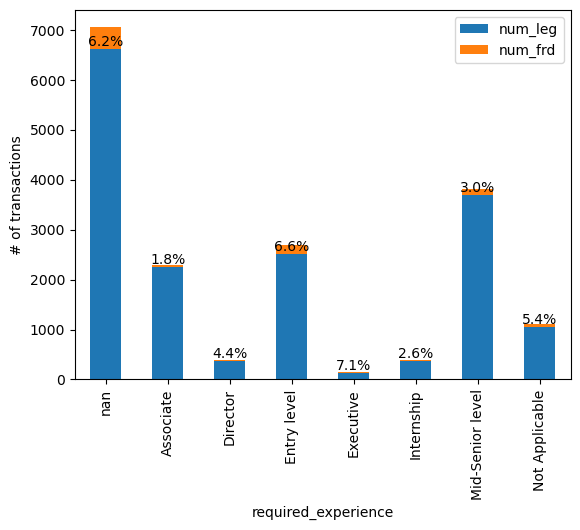

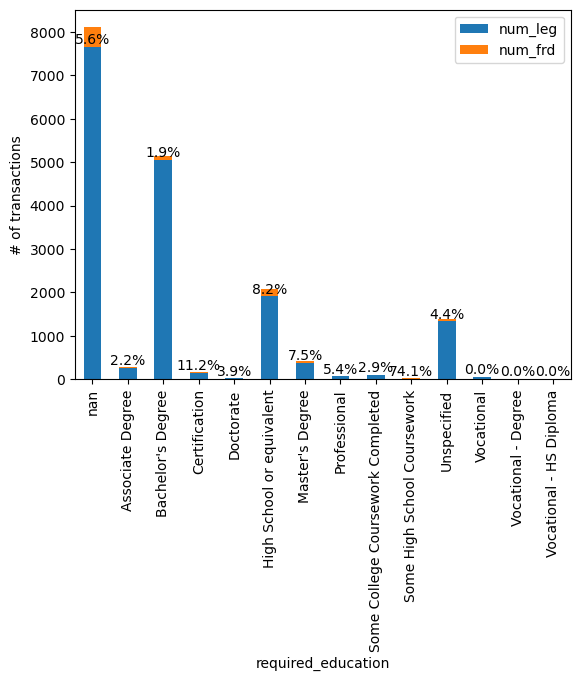

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


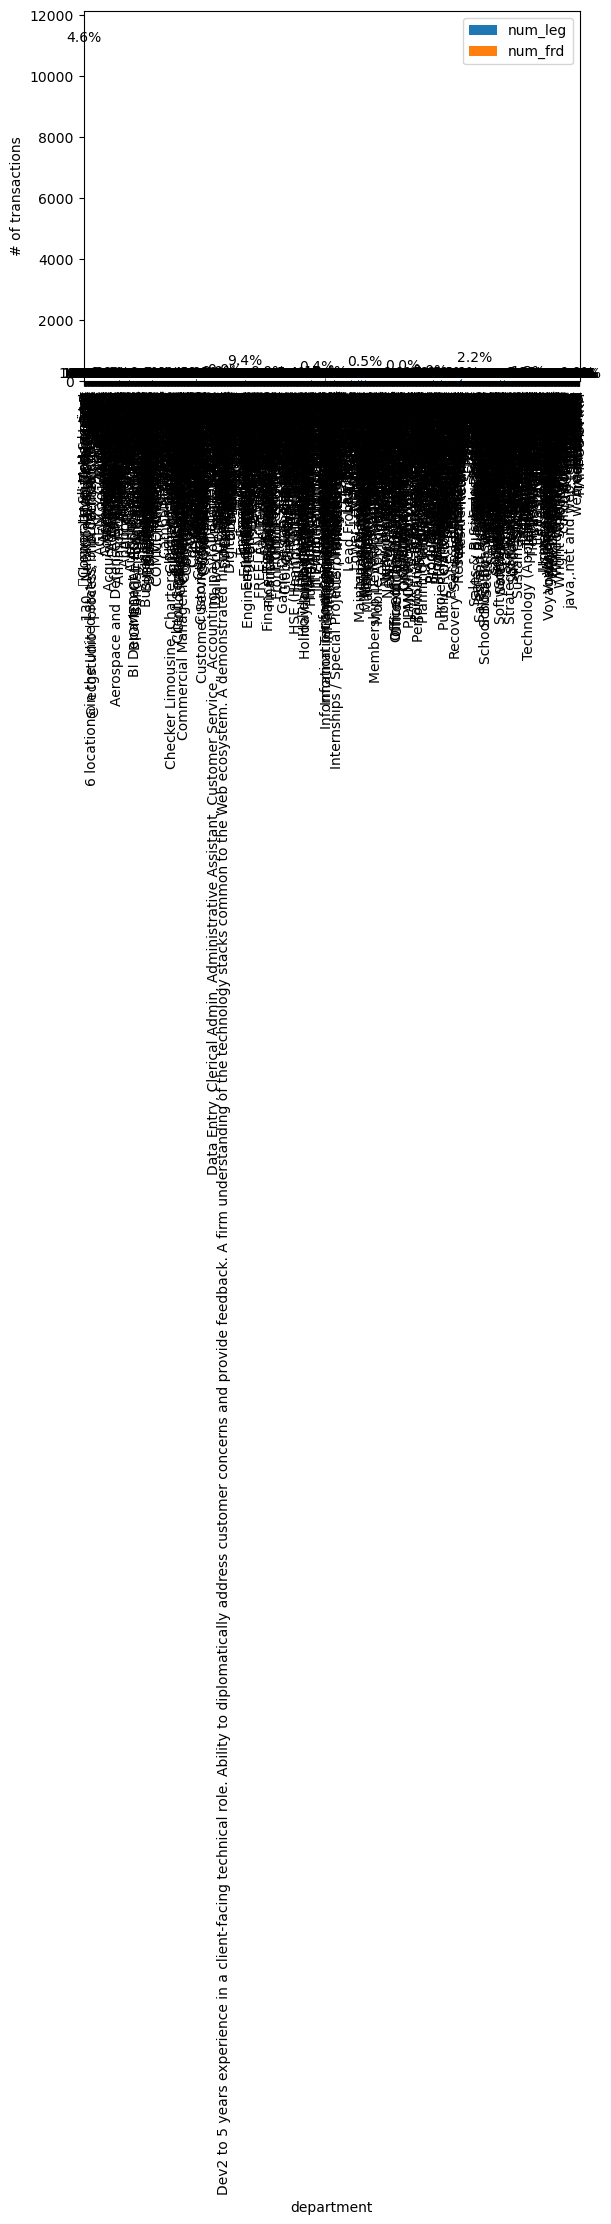

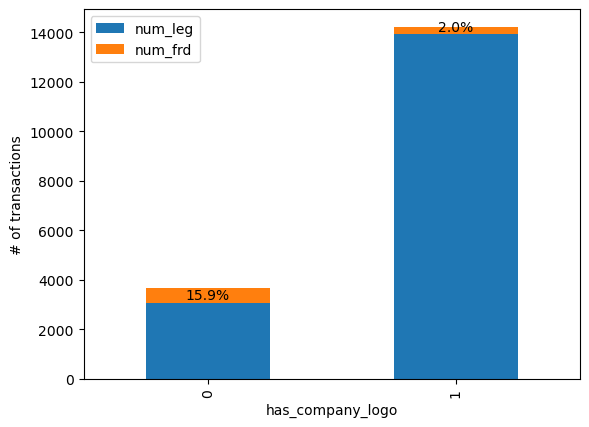

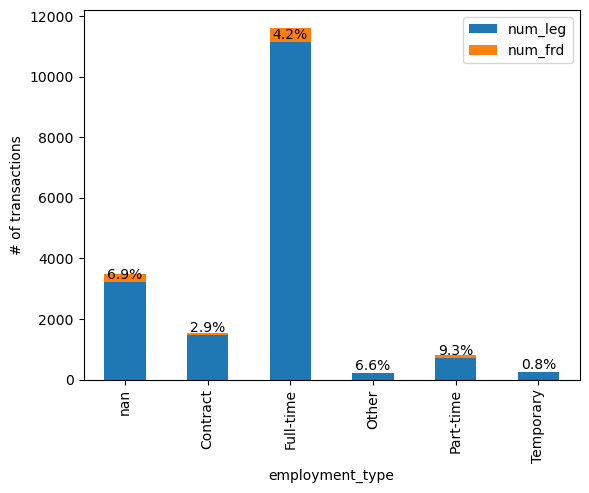

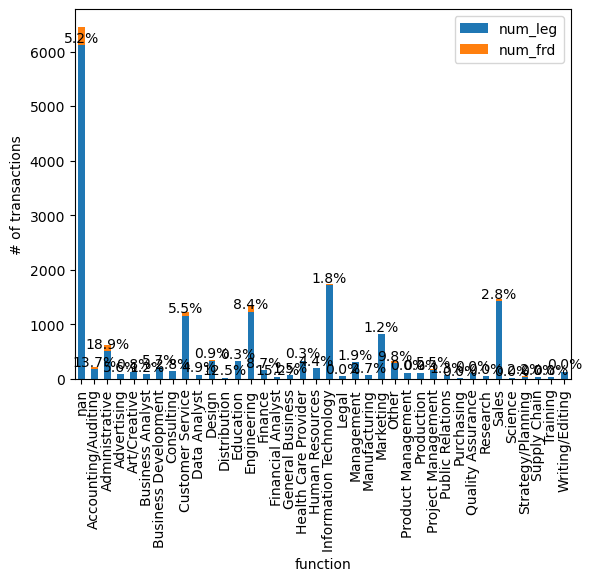

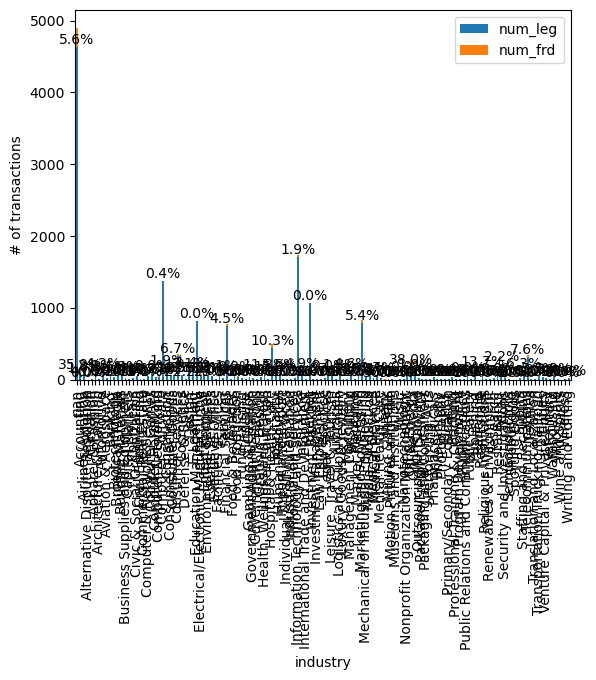

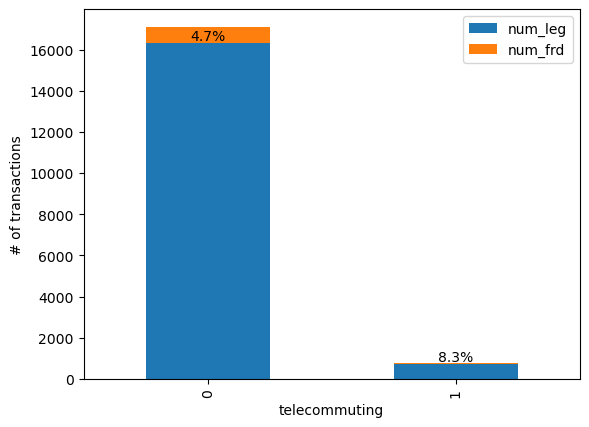

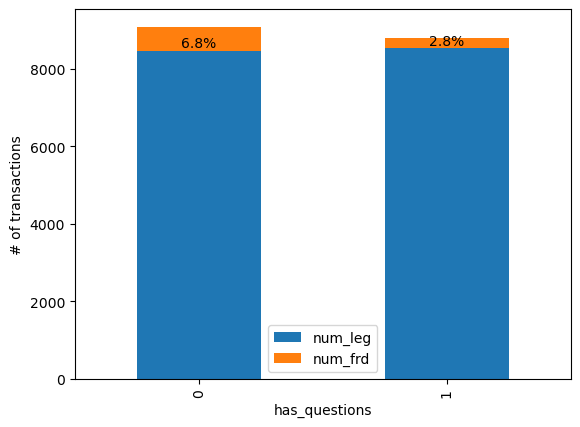

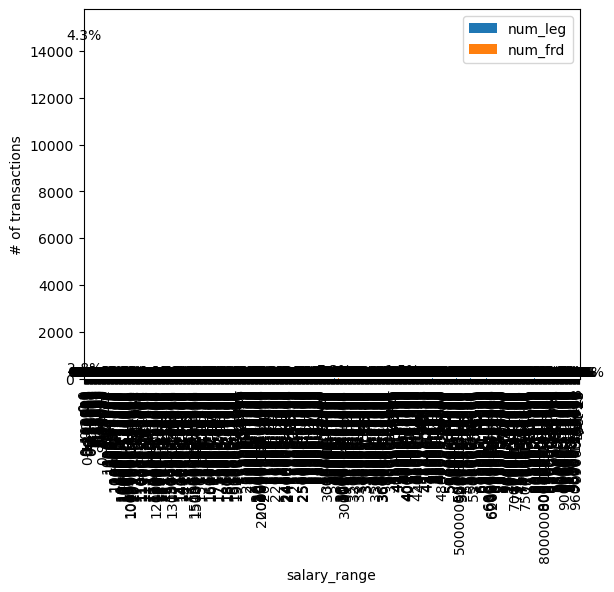

In [9]:
for f in cat_feature:
    ans = data[[f,"fraudulent"]].groupby([f, "fraudulent"],dropna=False).size().reset_index(name='num').pivot(index=f, columns="fraudulent", values='num').fillna(0)
    ans.columns = ['num_leg','num_frd']
    ax = ans.plot.bar(stacked=True)
    ans['fraud_rate'] = np.round(100*ans['num_frd'] / (ans['num_frd'] + ans['num_leg']), 2)
    # ax.bar_label(ax.containers[0], f'{ax.containers[0]:.1f}%, labels=ans['fraud_rate'].values)
    ax.bar_label(ax.containers[0], labels=[f'{x:.1f}%' for x in ans['fraud_rate'].values])
    ax.set_ylabel("# of transactions")
    plt.show()

### 1.3 Combining categorical features and text features that do not have clear boundaries

In [10]:
data['text'] = data[['title', 'company_profile', 'requirements', 'description', 'benefits', 'department', 'employment_type', 'required_education', 
                     'industry', 'function', 'location']].fillna('').apply(lambda x: ' '.join(x.astype(str)), axis=1)
text_data_0 = " ".join(data[data['fraudulent'] == 0]['text'])
text_data_1 = " ".join(data[data['fraudulent'] == 1]['text'])

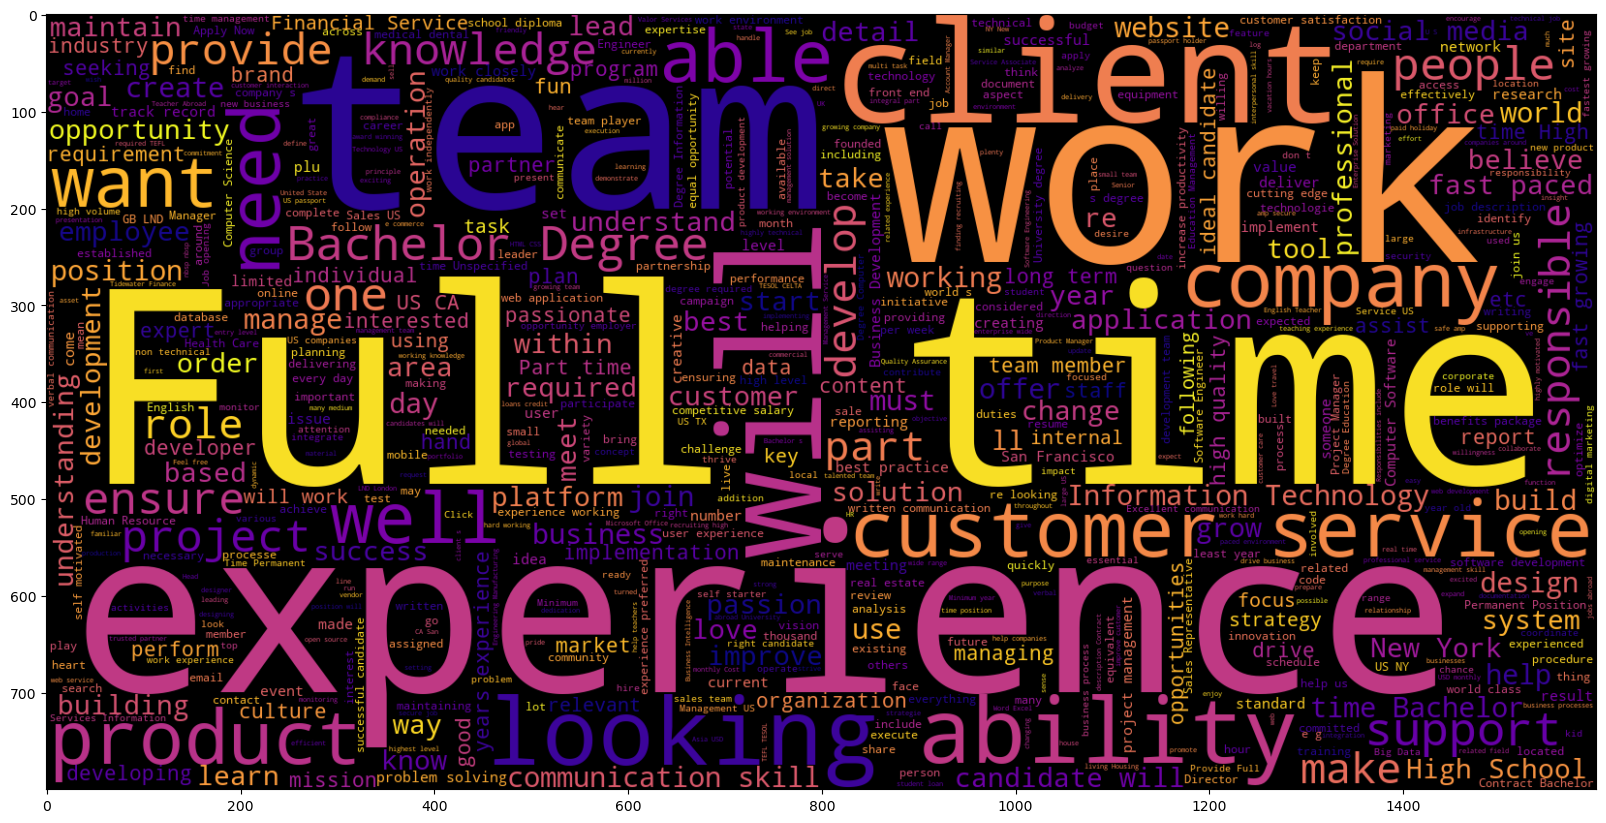

In [11]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000, colormap='plasma').generate(text_data_0)
plt.imshow(wc , interpolation = 'bilinear')

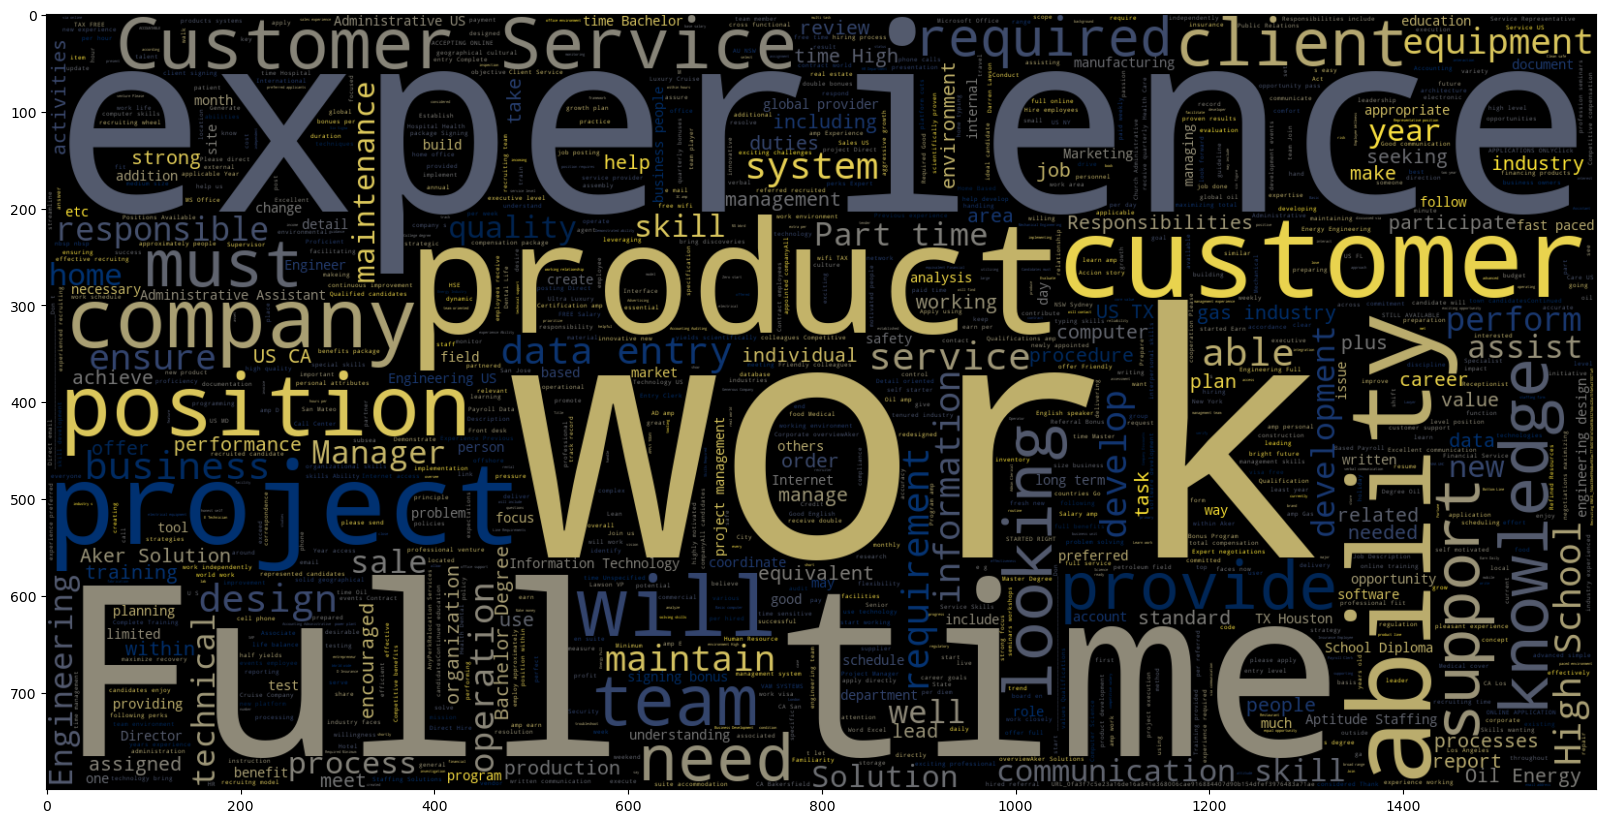

In [12]:
plt.figure(figsize = (20,20)) # Text that is fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000, colormap='cividis').generate(text_data_1)
plt.imshow(wc , interpolation = 'bilinear')

In [13]:
text = data[['text', 'fraudulent']]
text.head(3)

text  fraudulent
0  Marketing Intern We're Food52, and we've creat...           0
1  Customer Service - Cloud Video Production 90 S...           0
2  Commissioning Machinery Assistant (CMA) Valor ...           0

### 1.4 Text Cleaning

#### 1.4.1 Use stopwords to remove commonly used words from the text that generally do not contribute to the meaning of the text. 

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lixiaohua/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [17]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

In [18]:
text['cleaned_text'] = text['text'].apply(remove_stopwords)
text.head(10)

/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_60778/441606553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['cleaned_text'] = text['text'].apply(remove_stopwords)


text  fraudulent  \
0  Marketing Intern We're Food52, and we've creat...           0   
1  Customer Service - Cloud Video Production 90 S...           0   
2  Commissioning Machinery Assistant (CMA) Valor ...           0   
3  Account Executive - Washington DC Our passion ...           0   
4  Bill Review Manager SpotSource Solutions LLC i...           0   
5  Accounting Clerk   Job OverviewApex is an envi...           0   
6  Head of Content (m/f) Founded in 2009, the Fon...           0   
7  Lead Guest Service Specialist    Airenvy’s mis...           0   
8  HP BSM SME Solutions3 is a woman-owned small b...           0   
9  Customer Service Associate - Part Time  Novite...           0   

                                        cleaned_text  
0  Marketing Intern We're Food52, we've created g...  
1  Customer Service Cloud Video Production 90 Sec...  
2  Commissioning Machinery Assistant (CMA) Valor ...  
3  Account Executive Washington DC Our passion im...  
4  Bill Review Manager SpotSource Solutions LLC G...  
5  Accounting Clerk Job OverviewApex environmenta...  
6  Head Content (m/f) Founded 2009, Fonpit AG ros...  
7  Lead Guest Service Specialist Airenvy’s missio...  
8  HP BSM SME Solutions3 woman-owned small busine...  
9  Customer Service Associate Part Time Novitex E...

In [24]:
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lixiaohua/nltk_data...


True

####  1.4.2 Convert detailed part-of-speech (POS) tags, provided by functions like nltk.pos_tag(), into simpler categories that the WordNet lemmatizer understands. 
A lemmatizer is a tool used in Natural Language Processing (NLP) to reduce words to their base or root form, known as the lemma. Unlike stemming, which can chop off word endings, lemmatization considers the context and transforms words to their meaningful base form. Eg, "running" to "run", "better" to "good".\
'J' → Adjective (wordnet.ADJ)\
'V' → Verb (wordnet.VERB)\
'N' → Noun (wordnet.NOUN)\
'R' → Adverb (wordnet.ADV)

In [19]:
from nltk.corpus import wordnet

def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to NOUN if no match


In [25]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text)  

text['cleaned_text1'] = text['cleaned_text'].apply(lemmatize_words)

/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_60778/3486429180.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['cleaned_text1'] = text['cleaned_text'].apply(lemmatize_words)


In [26]:
text.head(10)

text  fraudulent  \
0  Marketing Intern We're Food52, and we've creat...           0   
1  Customer Service - Cloud Video Production 90 S...           0   
2  Commissioning Machinery Assistant (CMA) Valor ...           0   
3  Account Executive - Washington DC Our passion ...           0   
4  Bill Review Manager SpotSource Solutions LLC i...           0   
5  Accounting Clerk   Job OverviewApex is an envi...           0   
6  Head of Content (m/f) Founded in 2009, the Fon...           0   
7  Lead Guest Service Specialist    Airenvy’s mis...           0   
8  HP BSM SME Solutions3 is a woman-owned small b...           0   
9  Customer Service Associate - Part Time  Novite...           0   

                                        cleaned_text  \
0  Marketing Intern We're Food52, we've created g...   
1  Customer Service Cloud Video Production 90 Sec...   
2  Commissioning Machinery Assistant (CMA) Valor ...   
3  Account Executive Washington DC Our passion im...   
4  Bill Review Manager SpotSource Solutions LLC G...   
5  Accounting Clerk Job OverviewApex environmenta...   
6  Head Content (m/f) Founded 2009, Fonpit AG ros...   
7  Lead Guest Service Specialist Airenvy’s missio...   
8  HP BSM SME Solutions3 woman-owned small busine...   
9  Customer Service Associate Part Time Novitex E...   

                                       cleaned_text1  
0  marketing intern we're food52, we've create gr...  
1  customer service cloud video production 90 sec...  
2  commissioning machinery assistant (cma) valor ...  
3  account executive washington dc passion improv...  
4  bill review manager spotsource solutions llc g...  
5  accounting clerk job overviewapex environmenta...  
6  head content (m/f) founded 2009, fonpit ag ris...  
7  lead guest service specialist airenvy’s missio...  
8  hp bsm sme solutions3 woman-owned small busine...  
9  customer service associate part time novitex e...

#### 1.4.3 Remove random symbols

In [27]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()  # Convert text to lower case
    text = re.sub('\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub('\n', '', text)  # Remove line breaks
    text = re.sub('\w*\d\w*', '', text)  # Remove words containing numbers
    return text

In [28]:
# Applying the cleaning function to the dataset
text['cleaned_text2'] = text['cleaned_text1'].apply(lambda x: clean_text(x))
text.head(10)

/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_60778/1382006029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['cleaned_text2'] = text['cleaned_text1'].apply(lambda x: clean_text(x))


text  fraudulent  \
0  Marketing Intern We're Food52, and we've creat...           0   
1  Customer Service - Cloud Video Production 90 S...           0   
2  Commissioning Machinery Assistant (CMA) Valor ...           0   
3  Account Executive - Washington DC Our passion ...           0   
4  Bill Review Manager SpotSource Solutions LLC i...           0   
5  Accounting Clerk   Job OverviewApex is an envi...           0   
6  Head of Content (m/f) Founded in 2009, the Fon...           0   
7  Lead Guest Service Specialist    Airenvy’s mis...           0   
8  HP BSM SME Solutions3 is a woman-owned small b...           0   
9  Customer Service Associate - Part Time  Novite...           0   

                                        cleaned_text  \
0  Marketing Intern We're Food52, we've created g...   
1  Customer Service Cloud Video Production 90 Sec...   
2  Commissioning Machinery Assistant (CMA) Valor ...   
3  Account Executive Washington DC Our passion im...   
4  Bill Review Manager SpotSource Solutions LLC G...   
5  Accounting Clerk Job OverviewApex environmenta...   
6  Head Content (m/f) Founded 2009, Fonpit AG ros...   
7  Lead Guest Service Specialist Airenvy’s missio...   
8  HP BSM SME Solutions3 woman-owned small busine...   
9  Customer Service Associate Part Time Novitex E...   

                                       cleaned_text1  \
0  marketing intern we're food52, we've create gr...   
1  customer service cloud video production 90 sec...   
2  commissioning machinery assistant (cma) valor ...   
3  account executive washington dc passion improv...   
4  bill review manager spotsource solutions llc g...   
5  accounting clerk job overviewapex environmenta...   
6  head content (m/f) founded 2009, fonpit ag ris...   
7  lead guest service specialist airenvy’s missio...   
8  hp bsm sme solutions3 woman-owned small busine...   
9  customer service associate part time novitex e...   

                                       cleaned_text2  
0  marketing intern were  weve create groundbreak...  
1  customer service cloud video production  secon...  
2  commissioning machinery assistant cma valor se...  
3  account executive washington dc passion improv...  
4  bill review manager spotsource solutions llc g...  
5  accounting clerk job overviewapex environmenta...  
6  head content mf founded  fonpit ag rise intern...  
7  lead guest service specialist airenvy’s missio...  
8  hp bsm sme  womanowned small business whose fo...  
9  customer service associate part time novitex e...

### This time the word cloud clearly shows that "bachelors degree" is pretty significant in the non-fraudulent class.

In [29]:
text_data_0 = " ".join(text[text['fraudulent'] == 0]['cleaned_text2'])
text_data_1 = " ".join(text[text['fraudulent'] == 1]['cleaned_text2'])

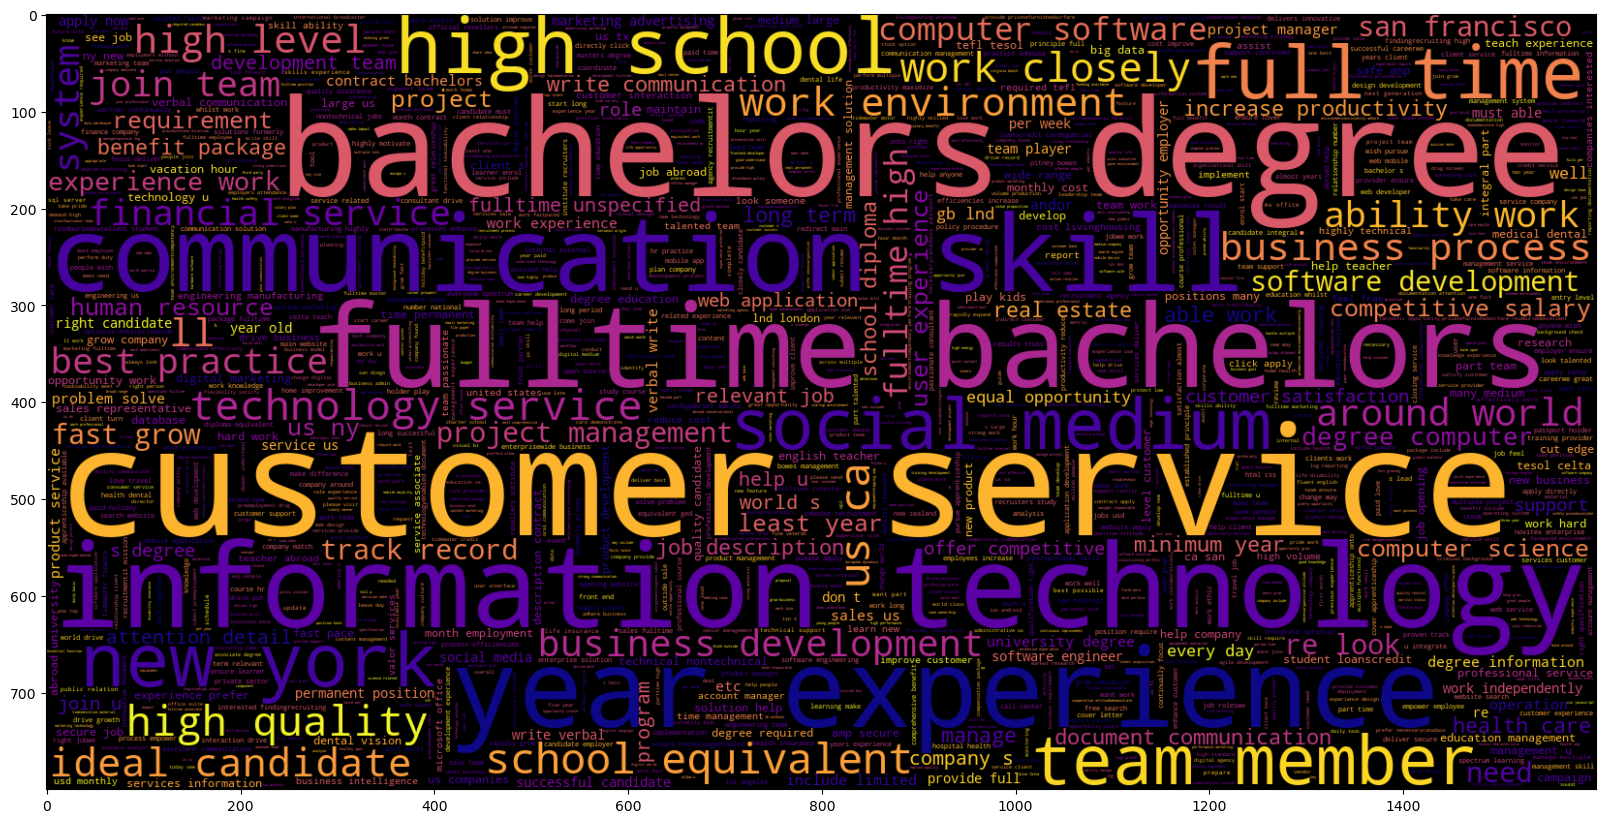

In [30]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000, colormap='plasma').generate(text_data_0)
plt.imshow(wc , interpolation = 'bilinear')

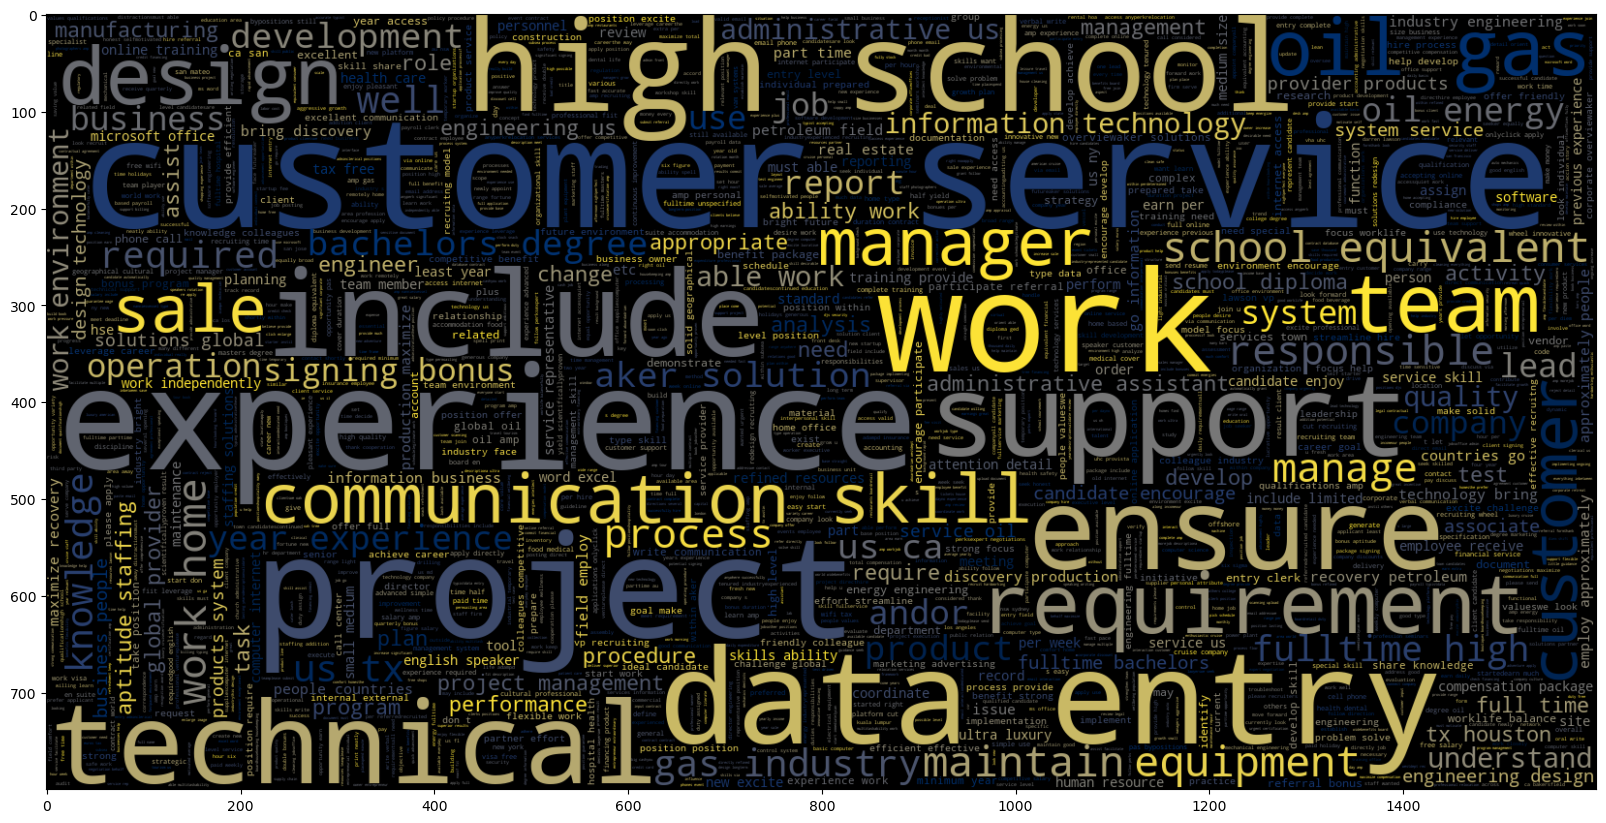

In [31]:
plt.figure(figsize = (20,20)) # Text that is fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000, colormap='cividis').generate(text_data_1)
plt.imshow(wc , interpolation = 'bilinear')

#### Try using the Tokenizer from the Natural Language Tool Kit, for fun....just to see how it is handling texts compared to previous steps.

In [32]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
# appling tokenizer5

text['cleaned_text3'] = text['cleaned_text2'].apply(lambda x: tokenizer.tokenize(x))
text.head(5)

/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_60778/2982704652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['cleaned_text3'] = text['cleaned_text2'].apply(lambda x: tokenizer.tokenize(x))


text  fraudulent  \
0  Marketing Intern We're Food52, and we've creat...           0   
1  Customer Service - Cloud Video Production 90 S...           0   
2  Commissioning Machinery Assistant (CMA) Valor ...           0   
3  Account Executive - Washington DC Our passion ...           0   
4  Bill Review Manager SpotSource Solutions LLC i...           0   

                                        cleaned_text  \
0  Marketing Intern We're Food52, we've created g...   
1  Customer Service Cloud Video Production 90 Sec...   
2  Commissioning Machinery Assistant (CMA) Valor ...   
3  Account Executive Washington DC Our passion im...   
4  Bill Review Manager SpotSource Solutions LLC G...   

                                       cleaned_text1  \
0  marketing intern we're food52, we've create gr...   
1  customer service cloud video production 90 sec...   
2  commissioning machinery assistant (cma) valor ...   
3  account executive washington dc passion improv...   
4  bill review manager spotsource solutions llc g...   

                                       cleaned_text2  \
0  marketing intern were  weve create groundbreak...   
1  customer service cloud video production  secon...   
2  commissioning machinery assistant cma valor se...   
3  account executive washington dc passion improv...   
4  bill review manager spotsource solutions llc g...   

                                       cleaned_text3  
0  [marketing, intern, were, weve, create, ground...  
1  [customer, service, cloud, video, production, ...  
2  [commissioning, machinery, assistant, cma, val...  
3  [account, executive, washington, dc, passion, ...  
4  [bill, review, manager, spotsource, solutions,...

In [33]:
text['cleaned_text4'] = text['cleaned_text3'].apply(lambda x: ' '.join(x))  # Join tokenized words into a string
target = text['fraudulent']
text.head(5)

/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_60778/645855652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['cleaned_text4'] = text['cleaned_text3'].apply(lambda x: ' '.join(x))  # Join tokenized words into a string


text  fraudulent  \
0  Marketing Intern We're Food52, and we've creat...           0   
1  Customer Service - Cloud Video Production 90 S...           0   
2  Commissioning Machinery Assistant (CMA) Valor ...           0   
3  Account Executive - Washington DC Our passion ...           0   
4  Bill Review Manager SpotSource Solutions LLC i...           0   

                                        cleaned_text  \
0  Marketing Intern We're Food52, we've created g...   
1  Customer Service Cloud Video Production 90 Sec...   
2  Commissioning Machinery Assistant (CMA) Valor ...   
3  Account Executive Washington DC Our passion im...   
4  Bill Review Manager SpotSource Solutions LLC G...   

                                       cleaned_text1  \
0  marketing intern we're food52, we've create gr...   
1  customer service cloud video production 90 sec...   
2  commissioning machinery assistant (cma) valor ...   
3  account executive washington dc passion improv...   
4  bill review manager spotsource solutions llc g...   

                                       cleaned_text2  \
0  marketing intern were  weve create groundbreak...   
1  customer service cloud video production  secon...   
2  commissioning machinery assistant cma valor se...   
3  account executive washington dc passion improv...   
4  bill review manager spotsource solutions llc g...   

                                       cleaned_text3  \
0  [marketing, intern, were, weve, create, ground...   
1  [customer, service, cloud, video, production, ...   
2  [commissioning, machinery, assistant, cma, val...   
3  [account, executive, washington, dc, passion, ...   
4  [bill, review, manager, spotsource, solutions,...   

                                       cleaned_text4  
0  marketing intern were weve create groundbreaki...  
1  customer service cloud video production second...  
2  commissioning machinery assistant cma valor se...  
3  account executive washington dc passion improv...  
4  bill review manager spotsource solutions llc g...

In [34]:
text.to_csv('text.csv', index=False)

### 2 Now preprocess for modeling

In [63]:
data_ext = data[['telecommuting', 'has_company_logo','has_questions','employment_type','required_experience']].fillna('None')
target = data[['fraudulent']]
text_ext = text[['cleaned_text4']]

In [56]:
from scipy.sparse import hstack, csr_matrix

In [69]:
data_encoded = pd.get_dummies(data_ext, drop_first=True)
binary_columns = ['telecommuting', 'has_company_logo', 'has_questions']
data_encoded[binary_columns] = data_encoded[binary_columns].astype(bool)

data_concat = pd.concat([data_encoded, text_ext], axis=1)
data_concat.head(5)

telecommuting  has_company_logo  has_questions  employment_type_Full-time  \
0          False              True          False                      False   
1          False              True          False                       True   
2          False              True          False                      False   
3          False              True          False                       True   
4          False              True           True                       True   

   employment_type_None  employment_type_Other  employment_type_Part-time  \
0                 False                   True                      False   
1                 False                  False                      False   
2                  True                  False                      False   
3                 False                  False                      False   
4                 False                  False                      False   

   employment_type_Temporary  required_experience_Director  \
0                      False                         False   
1                      False                         False   
2                      False                         False   
3                      False                         False   
4                      False                         False   

   required_experience_Entry level  required_experience_Executive  \
0                            False                          False   
1                            False                          False   
2                            False                          False   
3                            False                          False   
4                            False                          False   

   required_experience_Internship  required_experience_Mid-Senior level  \
0                            True                                 False   
1                           False                                 False   
2                           False                                 False   
3                           False                                  True   
4                           False                                  True   

   required_experience_None  required_experience_Not Applicable  \
0                     False                               False   
1                     False                                True   
2                      True                               False   
3                     False                               False   
4                     False                               False   

                                       cleaned_text4  
0  marketing intern were weve create groundbreaki...  
1  customer service cloud video production second...  
2  commissioning machinery assistant cma valor se...  
3  account executive washington dc passion improv...  
4  bill review manager spotsource solutions llc g...

In [77]:
data_concat_t = pd.concat([data_concat, target], axis=1)
data_concat_t.to_csv('data_concat_t.csv', index=False)

### 3 Modeling

#### 3.1 Baseline model using Logistic Regression classifier and TF-IDF Vectorizer

Term Frequency-Inverse Document Frequency (TF-IDF) to convert the text into a sparse matrix of features and fit a logistic regression model on it.\
Interestingly, the ROC-AUC is terrible.

In [73]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = []   
cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(data_concat, target):
    print('Fold {}'.format(cnt + 1))
    X_train, X_test = data_concat.iloc[train_ix], data_concat.iloc[test_ix]
    y_train, y_test = target.iloc[train_ix], target.iloc[test_ix]
    X_train_text, X_test_text = X_train['cleaned_text4'], X_test['cleaned_text4']

    # Appling TF-IDF Vectorizer
    tfidf_vec = TfidfVectorizer()
    X_train_vec = tfidf_vec.fit_transform(X_train_text)
    X_test_vec = tfidf_vec.transform(X_test_text)  

    X_train_rest_sparse = csr_matrix(X_train.drop(columns=['cleaned_text4']).values)
    X_test_rest_sparse = csr_matrix(X_test.drop(columns=['cleaned_text4']).values)
    
    X_train_combined = hstack([X_train_vec, X_train_rest_sparse])
    X_test_combined = hstack([X_test_vec, X_test_rest_sparse])
    
    lr = LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
    lr.fit(X_train_combined, y_train)
    
    y_preds = lr.predict(X_test_combined)
    auc = roc_auc_score(y_test, y_preds)
    print('{} AUC: {}'.format(cnt, auc))
    
    auc_buf.append(auc)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('AUC std score = {:.6f}'.format(np.std(auc_buf)))

Fold 1


/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0 AUC: 0.523121387283237
Fold 2


/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1 AUC: 0.5317919075144508
Fold 3


/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2 AUC: 0.5404624277456648
Fold 4


/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3 AUC: 0.5346820809248555
Fold 5


/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4 AUC: 0.5459770114942528
AUC mean score = 0.535207
AUC std score = 0.007767


#### 3.2 Try Count Vectorizer instead, this would be the baseline model

In [74]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = []   
cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(text['cleaned_text4'], target):
    print('Fold {}'.format(cnt + 1))
    X_train, X_test = data_concat.iloc[train_ix], data_concat.iloc[test_ix]
    y_train, y_test = target.iloc[train_ix], target.iloc[test_ix]
    X_train_text, X_test_text = X_train['cleaned_text4'], X_test['cleaned_text4']

    # Appling Count Vectorizer
    count_vectorizer = CountVectorizer()
    X_train_vec = count_vectorizer.fit_transform(X_train_text)
    X_test_vec = count_vectorizer.transform(X_test_text)    

    X_train_rest_sparse = csr_matrix(X_train.drop(columns=['cleaned_text4']).values)
    X_test_rest_sparse = csr_matrix(X_test.drop(columns=['cleaned_text4']).values)
    
    X_train_combined = hstack([X_train_vec, X_train_rest_sparse])
    X_test_combined = hstack([X_test_vec, X_test_rest_sparse])

    
    lr = LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
    lr.fit(X_train_combined, y_train)
    
    y_preds = lr.predict(X_test_combined)
    auc = roc_auc_score(y_test, y_preds)
    print('{} AUC: {}'.format(cnt, auc))
    
    auc_buf.append(auc)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('AUC std score = {:.6f}'.format(np.std(auc_buf)))

Fold 1


/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0 AUC: 0.8544628252188224
Fold 2


/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1 AUC: 0.8687667630907105
Fold 3


/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2 AUC: 0.8426082732169338
Fold 4


/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3 AUC: 0.9004117414250261
Fold 5


/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4 AUC: 0.8776936487664456
AUC mean score = 0.868789
AUC std score = 0.019849
